In [1]:
import torch
from tqdm import tqdm

from src.models.siamese_network import SiameseNetwork

model = SiameseNetwork()
model = model.to(device='mps', dtype=torch.float32)
model

SiameseNetwork(
  (googlenet): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [2]:
next(model.parameters()).device, next(model.parameters()).dtype

(device(type='mps', index=0), torch.float32)

In [3]:
import torchinfo

input_size = (1, 3, 64, 64)

summary = torchinfo.summary(
    model=model.to(device='cpu', dtype=torch.float32),
    input_size=[input_size, input_size],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)
summary

/Users/rkovalch/miniconda3/envs/cv-labs/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/rkovalch/miniconda3/envs/cv-labs/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
SiameseNetwork (SiameseNetwork)               [1, 3, 64, 64]       [1, 1]               --                   Partial
├─GoogLeNet (googlenet)                       [1, 3, 64, 64]       [1, 32]              --                   Partial
│    └─BasicConv2d (conv1)                    [1, 3, 64, 64]       [1, 64, 32, 32]      --                   False
│    │    └─Conv2d (conv)                     [1, 3, 64, 64]       [1, 64, 32, 32]      (9,408)              False
│    │    └─BatchNorm2d (bn)                  [1, 64, 32, 32]      [1, 64, 32, 32]      (128)                False
│    └─MaxPool2d (maxpool1)                   [1, 64, 32, 32]      [1, 64, 16, 16]      --                   --
│    └─BasicConv2d (conv2)                    [1, 64, 16, 16]      [1, 64, 16, 16]      --                   False
│    │    └─Conv2d (conv)                     [1, 64, 16, 16]      [1, 64, 

In [4]:
first_parameter = next(model.parameters())
input_shape = first_parameter.size()
input_shape

torch.Size([64, 3, 7, 7])

In [5]:
model = model.eval()

In [79]:
import torch
from torch import optim
from src.losses.contrastive_loss import ContrastiveLoss
from torch.utils.data import DataLoader
from src.datasets.siamese_dataset import SiameseDataset
from torchvision import datasets
from torchvision.transforms import transforms

training_percent = 0.8
manual_seed = 42

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='../data', train=True, transform=transform, download=False)
test_dataset = datasets.FashionMNIST(root='../data', train=False, transform=transform, download=False)

train_siamese_dataset = SiameseDataset(train_dataset)
test_siamese_dataset = SiameseDataset(test_dataset)
#
training_samples = int(len(train_siamese_dataset) * training_percent)
validation_samples = len(train_siamese_dataset) - training_samples
#
train_siamese_dataset, val_siamese_dataset = torch.utils.data.random_split(
    train_siamese_dataset,
    [training_samples, validation_samples],
    generator=torch.Generator().manual_seed(manual_seed),
)

# Create Siamese DataLoaders
train_siamese_loader = DataLoader(train_siamese_dataset, batch_size=256, shuffle=True) # 16
val_siamese_loader = DataLoader(val_siamese_dataset, batch_size=256, shuffle=True)
test_siamese_loader = DataLoader(test_siamese_dataset, batch_size=20, shuffle=False)

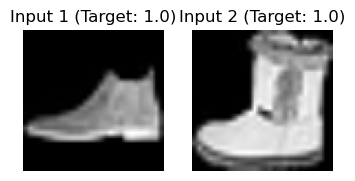

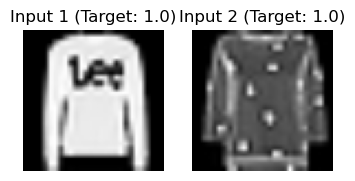

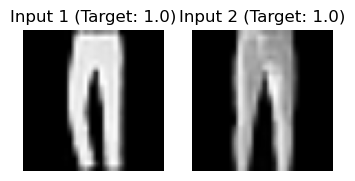

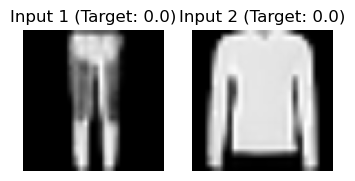

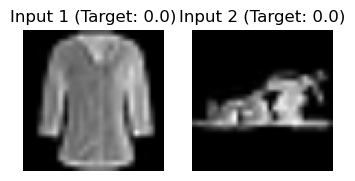

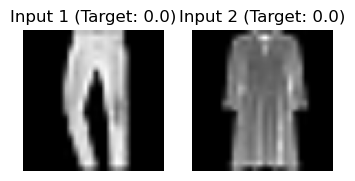

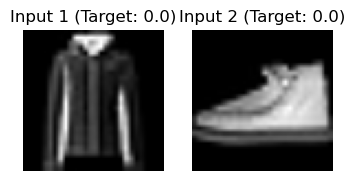

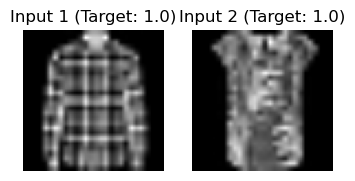

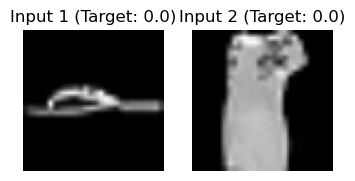

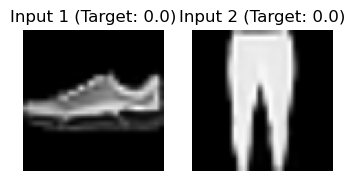

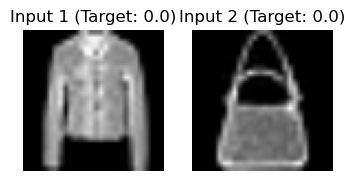

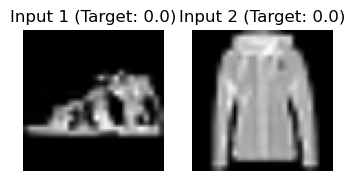

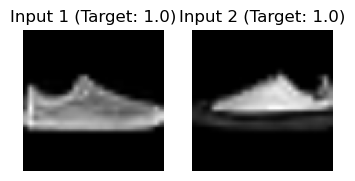

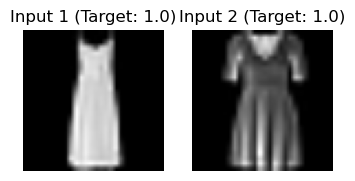

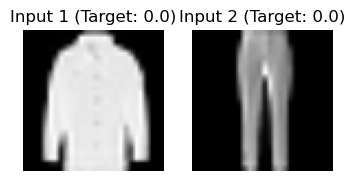

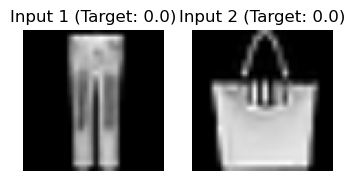

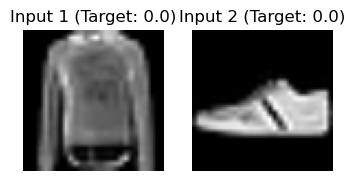

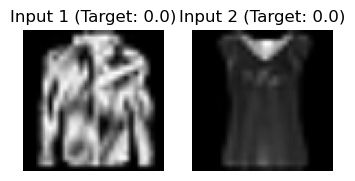

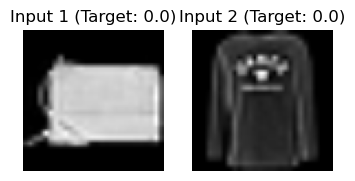

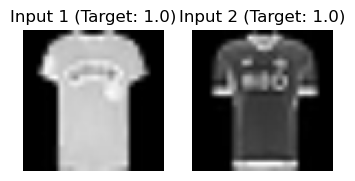

In [7]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

for x, y, t in test_siamese_loader:
    for item in range(x.size(0)):
        input1 = x[item]
        input2 = y[item]
        target = t[item]

        # Plot the input1 and input2 images
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(vutils.make_grid(input1, nrow=5, normalize=True).permute(1, 2, 0))
        plt.axis('off')
        plt.title('Input 1 (Target: {})'.format(target.item()))
        plt.subplot(1, 2, 2)
        plt.imshow(vutils.make_grid(input2, nrow=5, normalize=True).permute(1, 2, 0))
        plt.axis('off')
        plt.title('Input 2 (Target: {})'.format(target.item()))
        plt.show()

    break

In [90]:
from torch import nn
from torch.nn import BCELoss
from src.constants.training_constants import TrainingConstants
from datetime import datetime
from src.training_utils.early_stopper import EarlyStopper

tolerance = 3
min_delta = 1e-2
n_epochs = 20

model.train()
model = model.to(device='mps', dtype=torch.float32)
early_stopper = EarlyStopper(
    tolerance=tolerance,
    min_delta=min_delta,
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in tqdm(range(n_epochs), desc='Epoch'):
    loss_train = 0.0
    loss_val = 0.0
    total = 0

    for x, y, t in tqdm(train_siamese_loader, desc='Train', leave=False):
        x = x.repeat(1, 3, 1, 1).to(device='mps', dtype=torch.float32)
        y = y.repeat(1, 3, 1, 1).to(device='mps', dtype=torch.float32)
        t = t.half().to(device='mps', dtype=torch.float32)

        output = model(x=x, y=y)
        loss = loss_fn(output, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()

    with torch.no_grad():
        for x, y, t in tqdm(test_siamese_loader, desc='Val', leave=False):
            x = x.repeat(1, 3, 1, 1).to(device='mps', dtype=torch.float32)
            y = y.repeat(1, 3, 1, 1).to(device='mps', dtype=torch.float32)
            t = t.half().to(device='mps', dtype=torch.float32)

            output = model(x=x, y=y)
            loss = loss_fn(output, t)

            loss_val += loss.item()

    train_loss = loss_train / len(train_siamese_loader)
    val_loss = loss_val / len(test_siamese_loader)

    message = TrainingConstants.EPOCH_MESSAGE.format(
        time=datetime.now(),
        epoch=epoch,
        train_loss=train_loss,
        val_loss=val_loss,
    )
    print(message)

    early_stopper(float(val_loss))

    if early_stopper.early_stop:
        break

Train:  99%|█████████▉| 187/188 [00:33<00:00,  5.86it/s]
                                                        
Epoch:   5%|▌         | 1/20 [01:00<19:02, 60.11s/it] 


2023-04-18 11:01:32.800472
Epoch 0
Train loss 0.3635970853427623
Val loss 0.41337132041156294




Train: 100%|██████████| 188/188 [00:34<00:00,  6.37it/s]
                                                        
Epoch:  10%|█         | 2/20 [02:00<18:08, 60.48s/it] 


2023-04-18 11:02:33.540992
Epoch 1
Train loss 0.36090350816858574
Val loss 0.39488233149051666




Train: 100%|██████████| 188/188 [00:34<00:00,  6.28it/s]
                                                        
Epoch:  15%|█▌        | 3/20 [03:01<17:06, 60.37s/it] 


2023-04-18 11:03:33.777552
Epoch 2
Train loss 0.3565351143479347
Val loss 0.39512264367938044

Early stopping counter: 1 out of 3



Train:  99%|█████████▉| 187/188 [00:33<00:00,  5.67it/s]
                                                        
Epoch:  20%|██        | 4/20 [04:00<16:02, 60.14s/it] 


2023-04-18 11:04:33.576189
Epoch 3
Train loss 0.3470574436669654
Val loss 0.39327811285853387

Early stopping counter: 2 out of 3



Train:  99%|█████████▉| 187/188 [00:33<00:00,  5.58it/s]
                                                        
Epoch:  20%|██        | 4/20 [05:00<20:02, 75.14s/it] 


2023-04-18 11:05:33.266616
Epoch 4
Train loss 0.3416572902747925
Val loss 0.3983511726558209

Early stopping counter: 3 out of 3
Early stopping


500it [00:32, 15.58it/s]


Accuracy: 0.8380, Precision: 0.8560, Recall: 0.8102, F1 Score: 0.8325


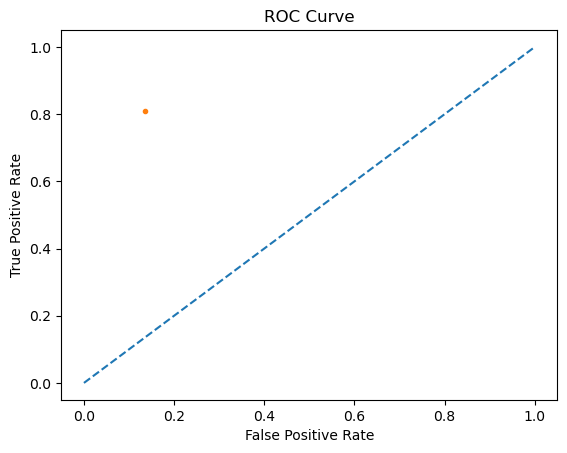

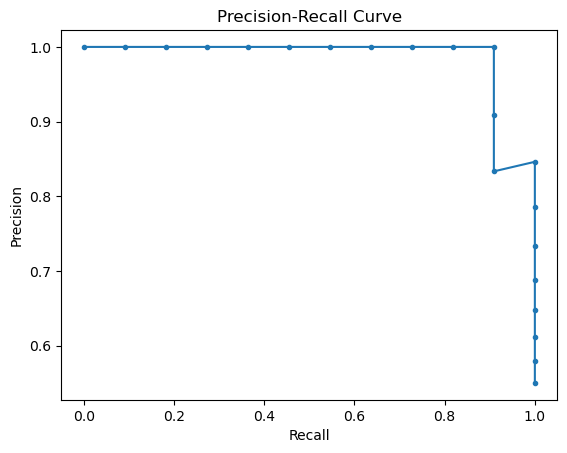

accuracy, precision, recall, f1_score


(0.838, 0.8560187154402382, 0.8101851851851852, 0.8324715615305067)

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve


def evaluate_siamese(model, test_loader, device, threshold=0.5):
    model.eval()
    with torch.no_grad():
        true_positive = 0
        false_positive = 0
        true_negative = 0
        false_negative = 0

        for i, (x, y, t) in tqdm(enumerate(test_loader)):
            x = x.repeat(1, 3, 1, 1).to(device=device, dtype=torch.float32)
            y = y.repeat(1, 3, 1, 1).to(device=device, dtype=torch.float32)
            t = t.half().to(device=device, dtype=torch.float32)

            output = model(x, y)

            for j in range(output.size(0)):
                if t[j] == 1 and output[j] >= threshold:
                    true_positive += 1
                elif t[j] == 0 and output[j] >= threshold:
                    false_positive += 1
                elif t[j] == 0 and output[j] < threshold:
                    true_negative += 1
                elif t[j] == 1 and output[j] < threshold:
                    false_negative += 1

        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1_score = 2 * precision * recall / (precision + recall)

        print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

        # Create error evaluation plots
        fpr = false_positive / (false_positive + true_negative)
        tpr = true_positive / (true_positive + false_negative)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()

        precision_values, recall_values, _ = precision_recall_curve(t.cpu().numpy(), output.cpu().numpy())
        plt.plot(recall_values, precision_values, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

        # Return evaluation metrics
        return accuracy, precision, recall, f1_score

accuracy, precision, recall, f1_score = evaluate_siamese(model, test_siamese_loader, device='mps', threshold=0.5)
print('accuracy, precision, recall, f1_score')
accuracy, precision, recall, f1_score

pred: 0.06258566677570343; pred_class: False; target: 0.0


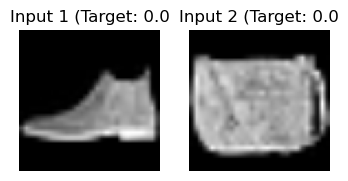

pred: 0.8684343695640564; pred_class: True; target: 1.0


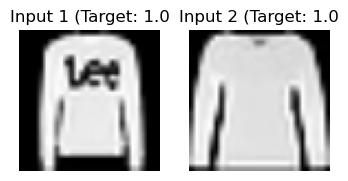

pred: 0.986644446849823; pred_class: True; target: 1.0


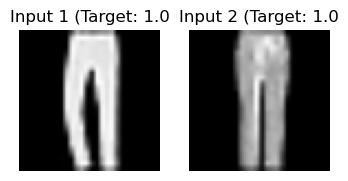

pred: 0.015798190608620644; pred_class: False; target: 0.0


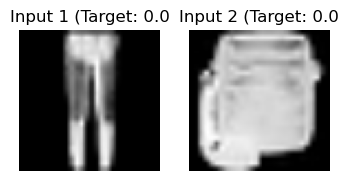

pred: 0.7373709082603455; pred_class: True; target: 1.0


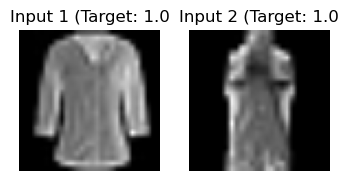

pred: 0.6884928941726685; pred_class: True; target: 1.0


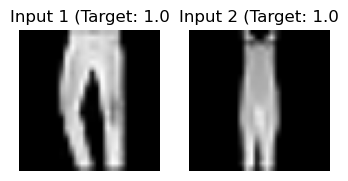

pred: 0.5920340418815613; pred_class: True; target: 1.0


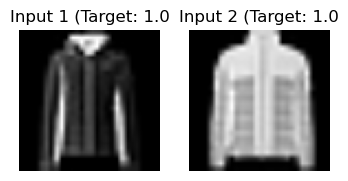

pred: 0.7268404960632324; pred_class: True; target: 1.0


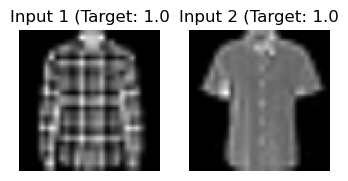

pred: 0.0011156144319102168; pred_class: False; target: 0.0


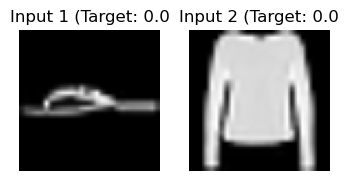

pred: 0.00011555453238543123; pred_class: False; target: 0.0


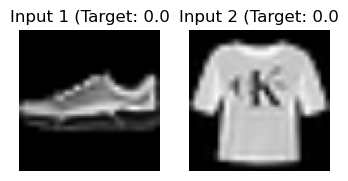

pred: 0.5369771122932434; pred_class: True; target: 1.0


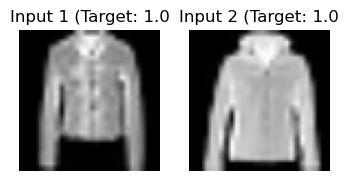

pred: 0.9921982884407043; pred_class: True; target: 1.0


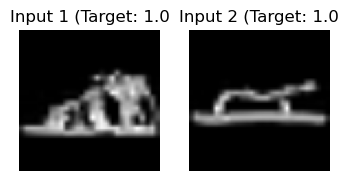

pred: 0.8744732141494751; pred_class: True; target: 1.0


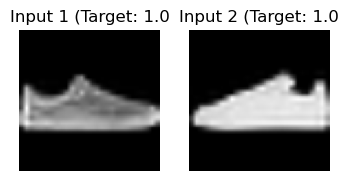

pred: 0.9082447290420532; pred_class: True; target: 1.0


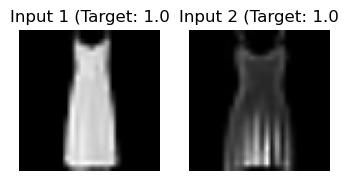

pred: 0.47623446583747864; pred_class: False; target: 1.0


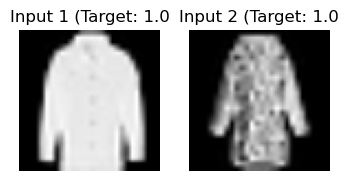

pred: 0.07002337276935577; pred_class: False; target: 0.0


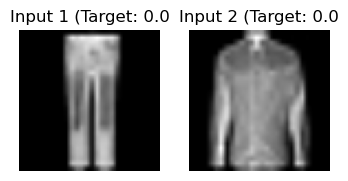

pred: 0.3062252998352051; pred_class: False; target: 1.0


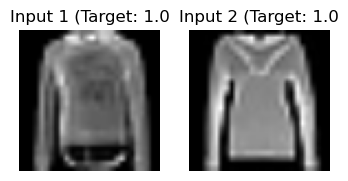

pred: 0.7004802227020264; pred_class: True; target: 1.0


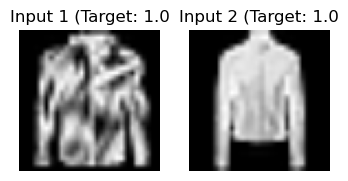

pred: 0.23437528312206268; pred_class: False; target: 0.0


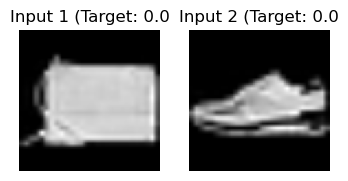

pred: 0.5158142447471619; pred_class: True; target: 1.0


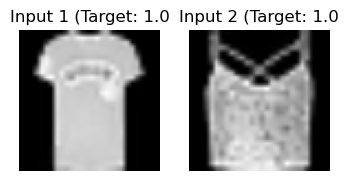

In [92]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

model.eval()
device='mps'
threshold = torch.tensor([0.5], device=device)

with torch.no_grad():
    for x, y, t in test_siamese_loader:
        x = x.repeat(1, 3, 1, 1).to(device=device, dtype=torch.float32)
        y = y.repeat(1, 3, 1, 1).to(device=device, dtype=torch.float32)
        t = t.half().to(device=device, dtype=torch.float32)

        preds = model(x, y)
        preds = torch.nn.Sigmoid()(preds)
        pred_classes = torch.gt(preds, threshold)

        for item in range(x.size(0)):
            input1 = x[item].cpu()
            input2 = y[item].cpu()
            target = t[item].cpu()
            pred = preds[item].cpu()
            pred_class = pred_classes[item].cpu()

            print(f'pred: {pred.item()}; pred_class: {pred_class.item()}; target: {target.item()}')

            # Plot the input1 and input2 images
            plt.figure(figsize=(4, 2))
            plt.subplot(1, 2, 1)
            plt.imshow(vutils.make_grid(input1, nrow=5, normalize=True).permute(1, 2, 0))
            plt.axis('off')
            plt.title(f'Input 1 (Target: {target.item()}')
            plt.subplot(1, 2, 2)
            plt.imshow(vutils.make_grid(input2, nrow=5, normalize=True).permute(1, 2, 0))
            plt.axis('off')
            plt.title(f'Input 2 (Target: {target.item()}')
            plt.show()

        break

In [93]:
import pandas as pd

feature_model = model.googlenet

model.eval()
feature_model.eval()
device='mps'
threshold = torch.tensor([0.5], device=device)

features_df = pd.DataFrame()

with torch.no_grad():
    for i, (x, t) in enumerate(DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)):
        x = x.repeat(1, 3, 1, 1).to(device=device, dtype=torch.float32)
        y = y.repeat(1, 3, 1, 1).to(device=device, dtype=torch.float32)
        t = t.half().to(device=device, dtype=torch.float32)

        preds = feature_model(x)
        print(preds.shape)

        break

torch.Size([10000, 32])


In [94]:
preds = preds.cpu().numpy()

In [95]:
targets = t.cpu().numpy()

In [96]:
from sklearn.manifold import TSNE

tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(preds)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 6.875708
[t-SNE] Computed conditional probabilities in 0.131s
[t-SNE] Iteration 50: error = 87.4822769, gradient norm = 0.0107160 (50 iterations in 1.365s)
[t-SNE] It

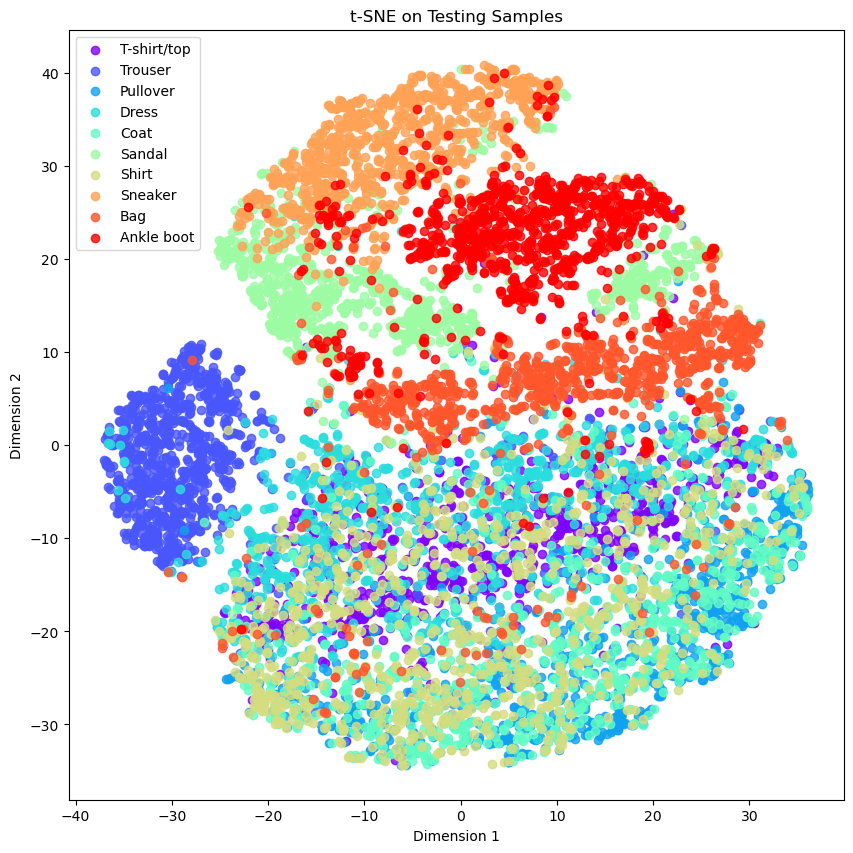

In [97]:
import numpy as np

obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[
            np.where(targets == c_group), 0
        ],
        tsne_features[
            np.where(targets == c_group), 1
        ],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show()

In [74]:
import os

model_name = 'adam-googlenet-32-64-16-16-16-1.pt'

PATH = os.path.join('../models', model_name)

torch.save(
    {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': 0,
        'train_loss': train_loss,
    },
    PATH
)